<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/04_Advanced_RAG_Cross_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Re-ranking with Cross encoder
This Notebook implements an advanced Re-ranking method with Cross encoder

This method re-ranks the retrieved documents according to a score that quantifies their relevancy with the input query.

To compute this score, we will use a cross-encoder.
A cross-encoder is a deep neural network that processes two input
sequences together as a single input. This allows the model to directly
compare and contrast the inputs, understanding their relationship in a more
integrated and nuanced way.

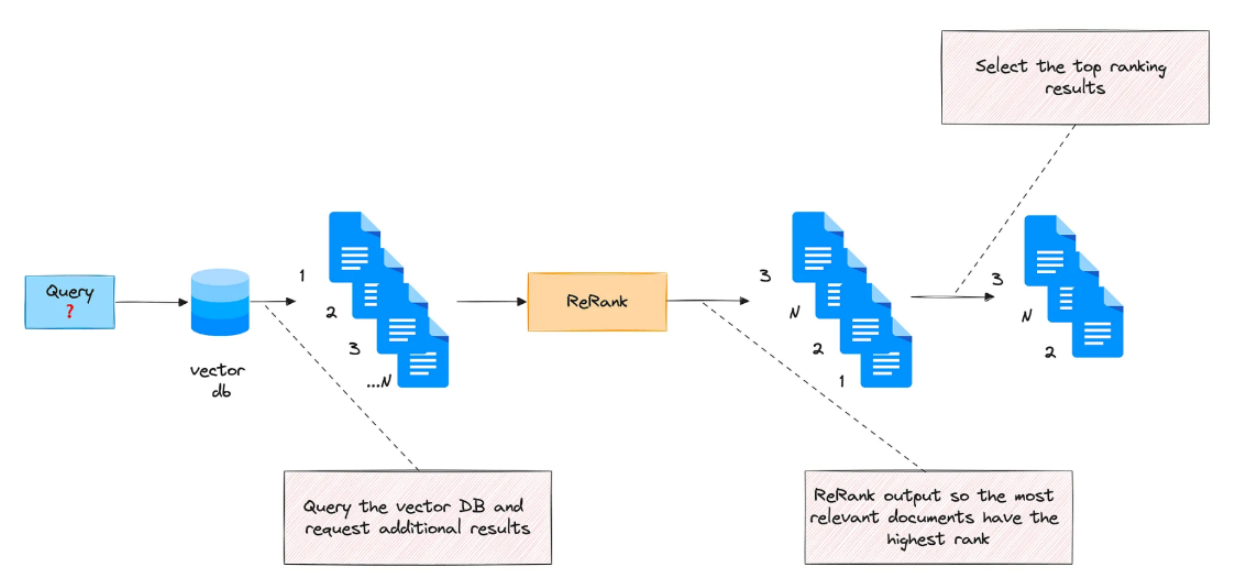

**Cross-encoders can be used for Information Retrieval:** given a query, encode
it with all retrieved documents. Then, sort them in a decreasing order. The
high-scored documents are the most relevant ones.

## Pre requisites

In [1]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 85 (delta 43), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (85/85), 11.02 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
!pip install -r /content/RAG/rag_requirements.txt

## Imports

In [4]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from IPython.display import Markdown
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()


True

In [5]:

from langchain.vectorstores import Chroma
from langchain.chat_models import AzureChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from RAG.utils import pretty_print_result, pretty_print_docs, get_answer

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [6]:
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')
EMBEDDING_API_KEY = os.getenv('API_KEY')
EMBEDDING_API_BASE = os.getenv('API_BASE')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

llm_gpt4_turbo = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
                              openai_api_key=EMBEDDING_API_KEY,
                              openai_api_base=EMBEDDING_API_BASE,
                              openai_api_version=API_VERSION,
                              openai_api_type=API_TYPE,
                              chunk_size=1)

## Retriever Creation

In [7]:
# Load pdf file
loader = PyPDFLoader("/content/RAG/data/Microsoft_2023.pdf")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, separators = ['\n\n','\n'])
splits = text_splitter.split_documents(data)

# VectorDB
vectordb = Chroma.from_documents(documents=splits, embedding=embeddings)

# Retriever
retriever = vectordb.as_retriever(search_type="similarity",
                                     search_kwargs={"k": 7, "include_metadata": True})

## Cross encoder

More on Cross Encoder @ https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2

In [8]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### 1. Get Relevant Docs

In [9]:
query = "What is the revenue trend of Microsoft in 2022?"

answer, sources = get_answer(query, llm_gpt4_turbo, retriever)

display(Markdown(answer.replace('$',"`$`")))

display(Markdown(pretty_print_docs(sources)))

The revenue trend of Microsoft in 2022 showed an increase, with Microsoft Cloud revenue growing to `$`91.4 billion from `$`69.1 billion in the previous fiscal year. Total revenue for the company also increased from `$`168,088 million in fiscal year 2021 to `$`198,270 million in fiscal year 2022.

Document 1:

supporting  and investing in our cloud -based services, including datacenter  operations ; designing, manufacturing, 
marketing, and selling our other products and service s; and income taxes.  
Highlights from fiscal year 2023  compared with fiscal year 2022  included:  
• Microsoft Cloud revenue increased 22% to $ 111.6 billion.  
• Office Commercial products and cloud services revenue increased  10% driven by Office 365 Commercial 
growth of  13%. 
• Office Consumer products and cloud services revenue increased  2% and Microsoft 365 Consumer 
subscribers increased to 67.0 million.  
• LinkedIn revenue increased  10%. 
• Dynamics products and cloud services revenue increased  16% driven by Dynamics 365 growth of 24%.

{'page': 36, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
----------------------------------------------------------------------------------------------------
Document 2:

Intelligent Cloud    37,884    33,203   14%  
More Personal Computing    16,450 

<IPython.core.display.Markdown object>

There are 7 documents retrived. Now let's use the power of cross encoder to create a CE score between each document and the query

#### 2. Reranking with Cross Encoder

In [10]:
retrieved_documents = []

for doc in sources:
    retrieved_documents.append(doc.page_content)

pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)

sorted_indices = np.argsort(scores)[::-1]

final_df = pd.DataFrame()
for s, o in enumerate(sorted_indices):
    data = {'Document': [sources[o].page_content] , 'metadata': [str(sources[o].metadata)], 'Cross_encoder_Score':[scores[o]], 'Cross_encoder_Rank': [s+1]}
    df = pd.DataFrame(data)
    final_df = pd.concat([final_df,df],ignore_index=True)

final_df

,Document,metadata,Cross_encoder_Score,Cross_encoder_Rank
0,supporting and investing in our cloud -based ...,"{'page': 36, 'source': '/content/RAG/data/Micr...",5.976963,1
1,"Intelligent Cloud 37,884 33,203 14% \...","{'page': 41, 'source': '/content/RAG/data/Micr...",3.422321,2
2,"16,230 \n 15,370 \nLinkedIn 15,145 ...","{'page': 91, 'source': '/content/RAG/data/Micr...",1.481097,3
3,driven by continued customer shift to cloud of...,"{'page': 41, 'source': '/content/RAG/data/Micr...",-0.469858,4
4,services. Azure and other cloud services reven...,"{'page': 41, 'source': '/content/RAG/data/Micr...",-1.563621,5
5,driven by demand for Microsoft 365. \n• Devic...,"{'page': 42, 'source': '/content/RAG/data/Micr...",-2.468213,6
6,Windows OEM revenue growth \n Revenue from s...,"{'page': 39, 'source': '/content/RAG/data/Micr...",-7.502937,7


#### 3. Apply Softmax

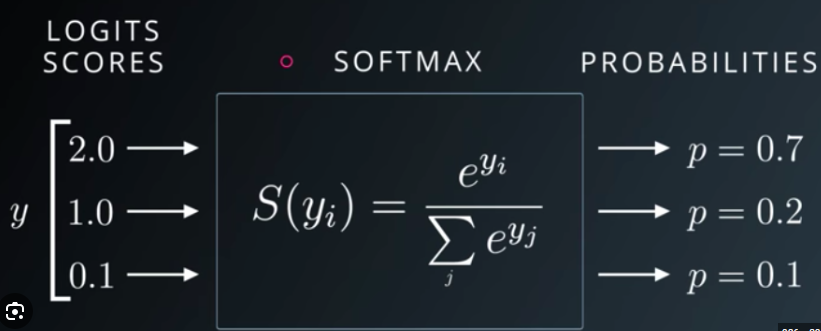

In [11]:
# softmax function to convert CE scores to probabilities
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

final_df['softmax_prob'] = softmax(final_df['Cross_encoder_Score'])
final_df

,Document,metadata,Cross_encoder_Score,Cross_encoder_Rank,softmax_prob
0,supporting and investing in our cloud -based ...,"{'page': 36, 'source': '/content/RAG/data/Micr...",5.976963,1,0.916416
1,"Intelligent Cloud 37,884 33,203 14% \...","{'page': 41, 'source': '/content/RAG/data/Micr...",3.422321,2,0.071224
2,"16,230 \n 15,370 \nLinkedIn 15,145 ...","{'page': 91, 'source': '/content/RAG/data/Micr...",1.481097,3,0.010223
3,driven by continued customer shift to cloud of...,"{'page': 41, 'source': '/content/RAG/data/Micr...",-0.469858,4,0.001453
4,services. Azure and other cloud services reven...,"{'page': 41, 'source': '/content/RAG/data/Micr...",-1.563621,5,0.000487
5,driven by demand for Microsoft 365. \n• Devic...,"{'page': 42, 'source': '/content/RAG/data/Micr...",-2.468213,6,0.000197
6,Windows OEM revenue growth \n Revenue from s...,"{'page': 39, 'source': '/content/RAG/data/Micr...",-7.502937,7,0.000001


In [12]:
# prompt: Using dataframe final_df: create a xy plot between Cross_encoder_Score and softmax_prob

import altair as alt
chart = alt.Chart(final_df).mark_circle().encode(x='Cross_encoder_Score', y='softmax_prob')
chart


alt.Chart(...)

#### 4. Filter for Top-K documents after reranking and generate the answer

In [13]:
from langchain.prompts import ChatPromptTemplate
from IPython.display import Markdown

qa_system_prompt = """
        You are a helpful AI assistant designed for answering questions based on the context provided. \
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

# filter for top 3 documents based on cross encoder score
top3_docs = final_df[final_df['Cross_encoder_Rank']<=3]['Document'].tolist()


chain = qa_prompt | llm_gpt4_turbo
result = chain.invoke({"question":query, "context": '\n\n'.join([doc for doc in top3_docs])})
Markdown(result.content.replace('$',"`$`"))

The revenue trend for Microsoft in fiscal year 2022 shows an increase compared to the previous fiscal year. According to the provided context, the total revenue for Microsoft in fiscal year 2022 was `$`198.270 billion, which is an increase from the `$`168.088 billion reported in fiscal year 2021. This indicates a positive revenue trend for Microsoft in 2022.

Here are the top k reranked documents

In [14]:
# print the top-K docs

print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d for i, d in enumerate(top3_docs)]))

Document 1:

supporting  and investing in our cloud -based services, including datacenter  operations ; designing, manufacturing, 
marketing, and selling our other products and service s; and income taxes.  
Highlights from fiscal year 2023  compared with fiscal year 2022  included:  
• Microsoft Cloud revenue increased 22% to $ 111.6 billion.  
• Office Commercial products and cloud services revenue increased  10% driven by Office 365 Commercial 
growth of  13%. 
• Office Consumer products and cloud services revenue increased  2% and Microsoft 365 Consumer 
subscribers increased to 67.0 million.  
• LinkedIn revenue increased  10%. 
• Dynamics products and cloud services revenue increased  16% driven by Dynamics 365 growth of 24%.
----------------------------------------------------------------------------------------------------
Document 2:

Intelligent Cloud    37,884    33,203   14%  
More Personal Computing    16,450     20,490   (20)%  
         
                
Total   $ 88,523